In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from scipy.stats import spearmanr
from statsmodels.graphics.tsaplots import plot_acf
import itertools
from itertools import product
import warnings
warnings.filterwarnings('ignore')  # 关闭所有警告

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [2]:
# 读取 Excel 文件
file_path = 'data.xlsx'

# 查看文件内所有sheet名，确认需要读取的sheet
xls = pd.ExcelFile(file_path)
print("Sheet names:", xls.sheet_names)

Sheet names: ['收盘价', '自由流通换手率']


In [3]:
# 读取 sheet1
df = pd.read_excel(file_path, sheet_name='收盘价')

In [4]:
# 将第一列（日期列）重命名为 'date'
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# 将 'date' 转换为 datetime 格式
df['date'] = pd.to_datetime(df['date'])

# 设置为 index
df = df.set_index('date')

# 检查结果
print(df.head())
print(df.index)

               50收益  中证1000全收益     800收益
date                                    
2005-01-04  835.130    989.984  983.8953
2005-01-05  839.529   1013.583  995.5764
2005-01-06  830.513   1005.466  986.2162
2005-01-07  831.641   1011.740  987.6929
2005-01-10  841.102   1023.638  997.1864
DatetimeIndex(['2005-01-04', '2005-01-05', '2005-01-06', '2005-01-07',
               '2005-01-10', '2005-01-11', '2005-01-12', '2005-01-13',
               '2005-01-14', '2005-01-17',
               ...
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19',
               '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
               '2025-06-26', '2025-06-27'],
              dtype='datetime64[ns]', name='date', length=4974, freq=None)


## 动量 + macd策略

In [5]:
def momentum_macd_combo_strategy_monthly(df, window=10, threshold=0.005, ema_short=8, ema_long=20):
    """
    动量 + MACD 共振组合策略（月度调仓）

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列（收盘价）
    - window: int，计算动量的窗口期
    - threshold: float，小盘相对大盘收益率超越大盘的阈值
    - ema_short, ema_long: int，MACD 参数

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列
    """

    # === 1) 计算动量信号 ===
    r_50 = df['50收益'].pct_change(periods=window)
    r_1000 = df['中证1000全收益'].pct_change(periods=window)
    momentum_signal = (r_1000 > r_50 + threshold)

    # === 2) 计算 MACD 信号 ===
    ema_short_1000 = df['中证1000全收益'].ewm(span=ema_short, adjust=False).mean()
    ema_long_1000 = df['中证1000全收益'].ewm(span=ema_long, adjust=False).mean()
    macd_signal = ema_short_1000 > ema_long_1000

    # === 3) 提取每月最后一个交易日 ===
    month_end_dates = df.resample('M').last().index

    # === 4) 初始化仓位 ===
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    current_pos_50 = 1  # 初始全仓大盘
    current_pos_1000 = 0

    # === 5) 根据信号更新仓位 ===
    for date in df.index:
        if date in month_end_dates:
            # 共振条件：动量 + MACD 均指向小盘
            if momentum_signal.loc[date] or macd_signal.loc[date]:
                current_pos_50 = 0
                current_pos_1000 = 1
            else:
                current_pos_50 = 1
                current_pos_1000 = 0

            # 归一化
            total = current_pos_50 + current_pos_1000
            current_pos_50 /= total
            current_pos_1000 /= total

        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    # === 6) 输出结果 ===
    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df

### 回测

In [6]:
# 获取策略每日仓位
position_df = momentum_macd_combo_strategy_monthly(df)

# =============================
# 计算每日组合收益率
# =============================
returns_50 = df['50收益'].pct_change()
returns_1000 = df['中证1000全收益'].pct_change()
portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# =============================
# 计算净值与超额净值曲线
# =============================
portfolio_nav = (1 + portfolio_returns).cumprod()
benchmark_nav = df['800收益'] / df['800收益'].iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# =============================
# 计算回测指标
# =============================
annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

# =============================
# 输出结果
# =============================
print(f"【回测指标】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")

【回测指标】
年化收益率: 13.42%
年化波动率: 28.37%
夏普比率: 0.47
最大回撤: -72.42%
Calmar Ratio: 0.19


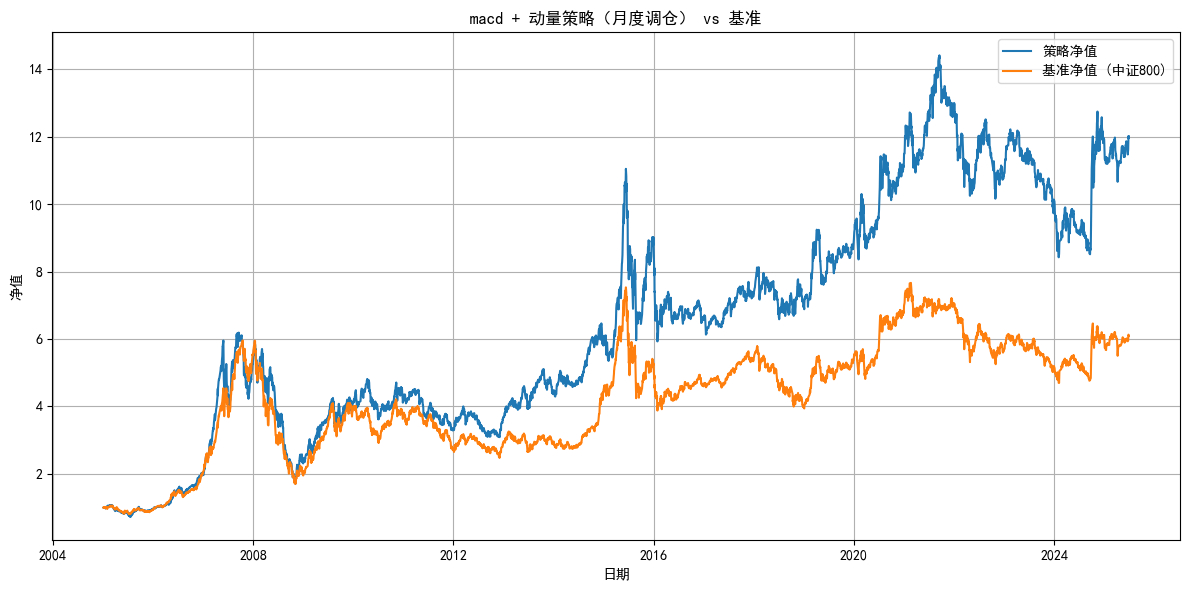

In [7]:
# 绘制净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav, label='策略净值')
plt.plot(benchmark_nav, label='基准净值 (中证800)')
plt.title('macd + 动量策略（月度调仓） vs 基准')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

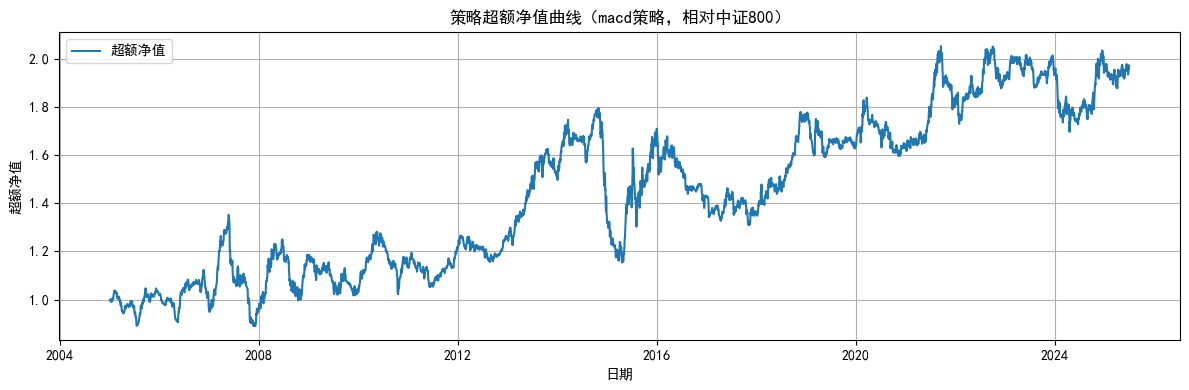

In [8]:
# 绘制超额净值曲线
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='超额净值')
plt.title('策略超额净值曲线（macd策略，相对中证800）')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 参数调优

In [9]:
# =============================
# 数据切分
# =============================

split_index_train = int(len(df) * 0.65)
split_index_val = int(len(df) * 0.8)

df_train = df.iloc[:split_index_train]
df_val = df.iloc[split_index_train:split_index_val]  # 验证集（测试集1）
df_test = df.iloc[split_index_val:]  # 测试集2

# =============================
# 参数网格
# =============================

window_range = [10, 20, 30]
threshold_range = [0.0, 0.005, 0.01]
ema_short_range = [8, 12]
ema_long_range = [20, 26]

# =============================
# 记录结果
# =============================

results = []

for window, threshold, ema_short, ema_long in itertools.product(window_range, threshold_range, ema_short_range, ema_long_range):
    
    # === 1) 训练集回测 ===
    position_df = momentum_macd_combo_strategy_monthly(df_train, window=window, threshold=threshold, ema_short=ema_short, ema_long=ema_long)

    returns_50 = df_train['50收益'].pct_change()
    returns_1000 = df_train['中证1000全收益'].pct_change()
    portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
    portfolio_returns = portfolio_returns.fillna(0)
    portfolio_nav = (1 + portfolio_returns).cumprod()

    # === 2) 计算指标 ===
    annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)

    # === 3) 存储结果 ===
    results.append({
        'window': window,
        'threshold': threshold,
        'ema_short': ema_short,
        'ema_long': ema_long,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    })

# =============================
# 输出Top 10
# =============================

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='calmar_ratio', ascending=False)

print("【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】")
print(results_df_sorted.head(10))

【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】
    window  threshold  ema_short  ema_long  annual_return  annual_vol  \
4       10      0.005          8        20       0.170949    0.311279   
8       10      0.010          8        20       0.170949    0.311279   
0       10      0.000          8        20       0.169302    0.311642   
7       10      0.005         12        26       0.166975    0.313228   
11      10      0.010         12        26       0.166975    0.313228   
9       10      0.010          8        26       0.166975    0.313228   
10      10      0.010         12        20       0.166975    0.313228   
6       10      0.005         12        20       0.166975    0.313228   
5       10      0.005          8        26       0.166975    0.313228   
3       10      0.000         12        26       0.165334    0.313589   

    sharpe_ratio  max_drawdown  calmar_ratio  
4       0.549183     -0.724238      0.236040  
8       0.549183     -0.724238      0.236040  
0       0.543259   

In [10]:
# =============================
# 在验证集（测试集1）上评估最优参数
# =============================

best_params = results_df_sorted.iloc[0]

position_val = momentum_macd_combo_strategy_monthly(
    df_val,
    window=int(best_params['window']),
    threshold=best_params['threshold'],
    ema_short=int(best_params['ema_short']),
    ema_long=int(best_params['ema_long'])
)

returns_50_val = df_val['50收益'].pct_change()
returns_1000_val = df_val['中证1000全收益'].pct_change()
portfolio_returns_val = position_val['position_50'] * returns_50_val + position_val['position_1000'] * returns_1000_val
portfolio_returns_val = portfolio_returns_val.fillna(0)
portfolio_nav_val = (1 + portfolio_returns_val).cumprod()

annual_return_val = portfolio_nav_val.iloc[-1] ** (252 / len(portfolio_nav_val)) - 1
annual_vol_val = portfolio_returns_val.std() * np.sqrt(252)
sharpe_ratio_val = annual_return_val / annual_vol_val
max_drawdown_val = (portfolio_nav_val / portfolio_nav_val.cummax() - 1).min()
calmar_ratio_val = annual_return_val / abs(max_drawdown_val)

print("\n【验证集（测试集1）表现】")
print(f"年化收益率: {annual_return_val:.2%}")
print(f"年化波动率: {annual_vol_val:.2%}")
print(f"夏普比率: {sharpe_ratio_val:.2f}")
print(f"最大回撤: {max_drawdown_val:.2%}")
print(f"Calmar Ratio: {calmar_ratio_val:.2f}")


【验证集（测试集1）表现】
年化收益率: 16.44%
年化波动率: 23.46%
夏普比率: 0.70
最大回撤: -17.68%
Calmar Ratio: 0.93


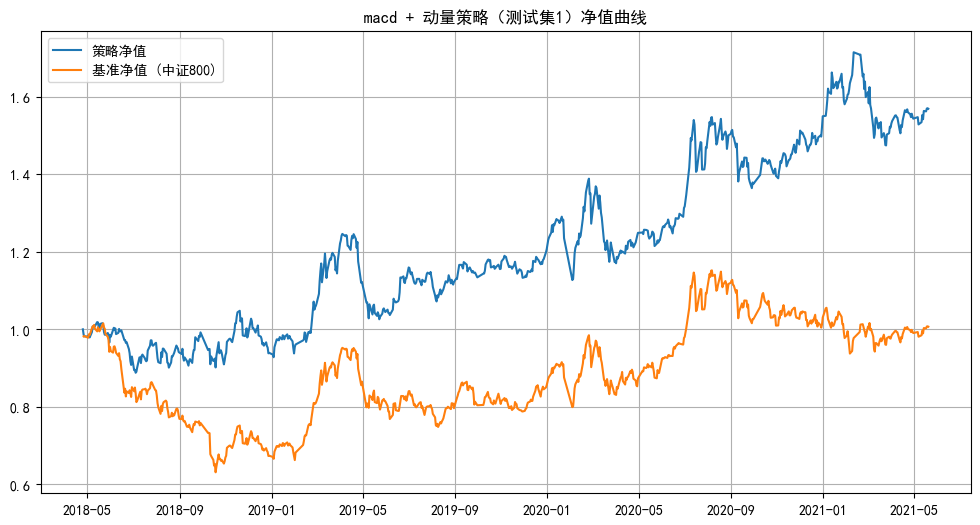

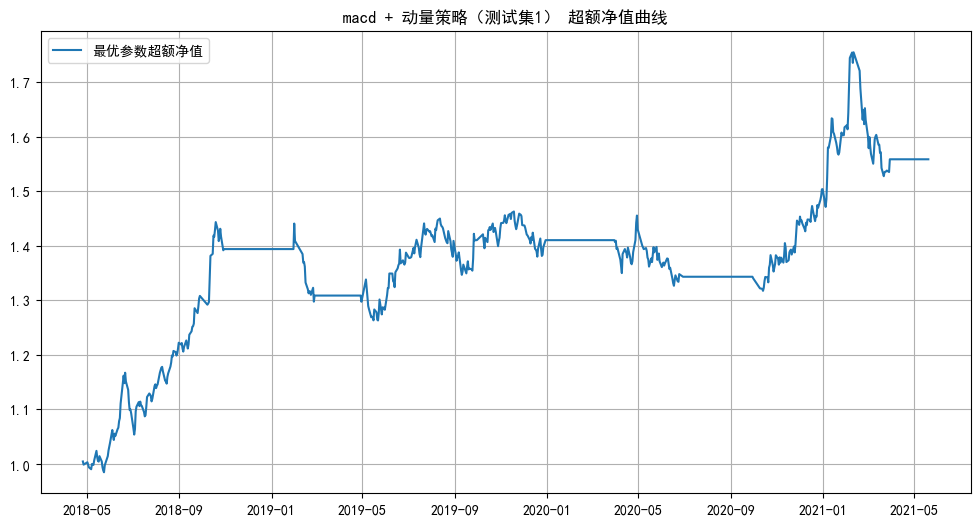

In [11]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_val = (1 + returns_1000_val).cumprod()

# 计算超额净值曲线
excess_nav_val = portfolio_nav_val / benchmark_nav_val


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_val.index, portfolio_nav_val, label='策略净值')
plt.plot(benchmark_nav_val.index, benchmark_nav_val, label='基准净值 (中证800)')
plt.title('macd + 动量策略（测试集1）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_val.index, excess_nav_val, label='最优参数超额净值')
plt.title('macd + 动量策略（测试集1） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# =============================
# 在测试集2上评估最优参数
# =============================

position_test = momentum_macd_combo_strategy_monthly(
    df_test,
    window=int(best_params['window']),
    threshold=best_params['threshold'],
    ema_short=int(best_params['ema_short']),
    ema_long=int(best_params['ema_long'])
)

returns_50_test = df_test['50收益'].pct_change()
returns_1000_test = df_test['中证1000全收益'].pct_change()
portfolio_returns_test = position_test['position_50'] * returns_50_test + position_test['position_1000'] * returns_1000_test
portfolio_returns_test = portfolio_returns_test.fillna(0)
portfolio_nav_test = (1 + portfolio_returns_test).cumprod()

annual_return_test = portfolio_nav_test.iloc[-1] ** (252 / len(portfolio_nav_test)) - 1
annual_vol_test = portfolio_returns_test.std() * np.sqrt(252)
sharpe_ratio_test = annual_return_test / annual_vol_test
max_drawdown_test = (portfolio_nav_test / portfolio_nav_test.cummax() - 1).min()
calmar_ratio_test = annual_return_test / abs(max_drawdown_test)

print("\n【测试集2（最终测试集）表现】")
print(f"年化收益率: {annual_return_test:.2%}")
print(f"年化波动率: {annual_vol_test:.2%}")
print(f"夏普比率: {sharpe_ratio_test:.2f}")
print(f"最大回撤: {max_drawdown_test:.2%}")
print(f"Calmar Ratio: {calmar_ratio_test:.2f}")


【测试集2（最终测试集）表现】
年化收益率: 1.23%
年化波动率: 21.58%
夏普比率: 0.06
最大回撤: -41.56%
Calmar Ratio: 0.03


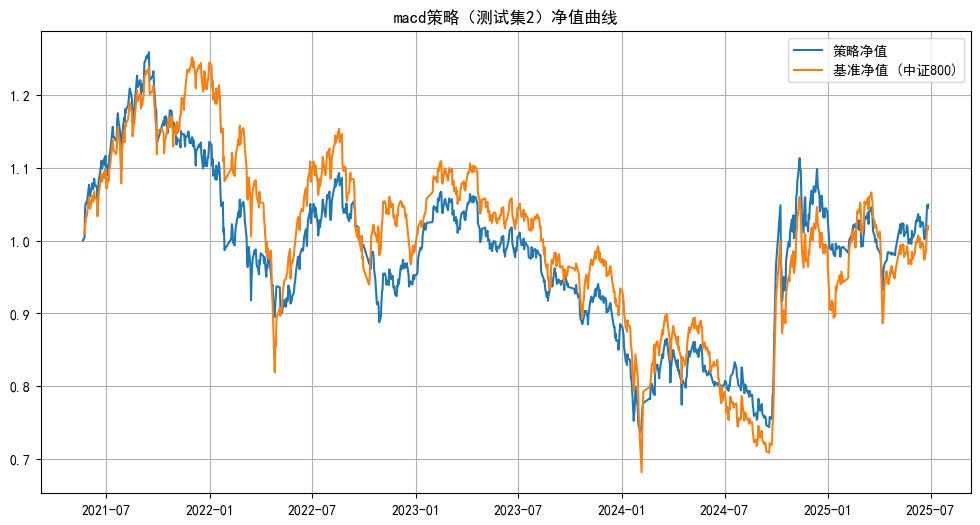

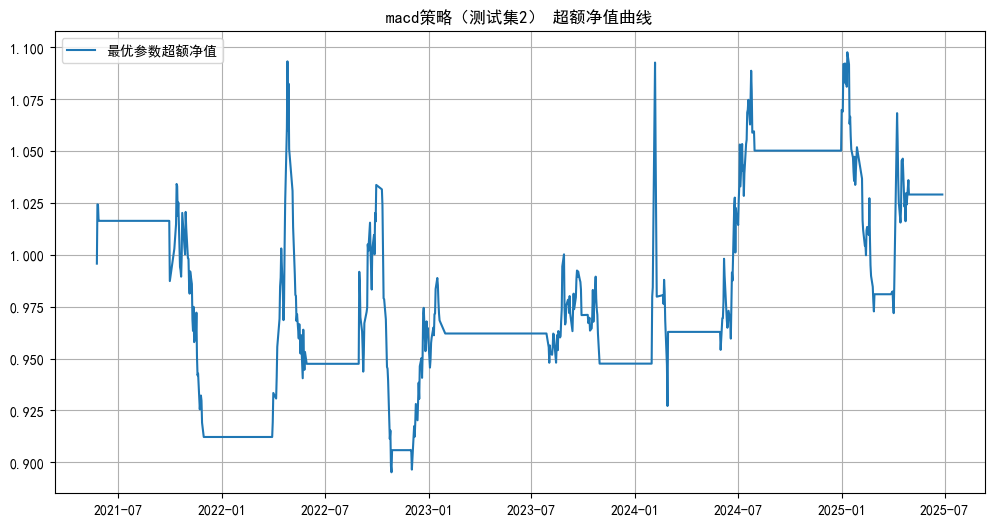

In [13]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_test = (1 + returns_1000_test).cumprod()

# 计算超额净值曲线
excess_nav_test = portfolio_nav_test / benchmark_nav_test


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_test.index, portfolio_nav_test, label='策略净值')
plt.plot(benchmark_nav_test.index, benchmark_nav_test, label='基准净值 (中证800)')
plt.title('macd策略（测试集2）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_test.index, excess_nav_test, label='最优参数超额净值')
plt.title('macd策略（测试集2） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()